In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.compose import ColumnTransformer
import missingno as msno
import warnings

warnings.filterwarnings("ignore")

First, we load the dataframe with the categorical variables from notebook 3.

In [13]:
df = pd.read_pickle('./data/df.pkl')
df.head(3)

,age,gender,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,...,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,CID
0,18,F,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,...,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0,xxxxxxxx
1,32,F,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,...,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0,CID
2,44,F,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,...,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1,CID


# Train-test-split

To avoid data-leakage, we first perform the train-test-split.

In [14]:
# define variables for X
X = df.drop("churn_risk_score", axis = 1) 
# define target
y = df["churn_risk_score"]  
# Split into train-data and test-data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering

In [15]:
# Extract hours
X_train["last_visit_time_hours"] = X_train["last_visit_time"].apply(lambda x: x.hour)
X_test["last_visit_time_hours"] = X_test["last_visit_time"].apply(lambda x: x.hour)

# Calculate days since joined as new feature
max_join = X_train["joining_date"].max()
X_train["days_since_join"] = (X_train["joining_date"] - max_join)
X_test["days_since_join"] = (X_test["joining_date"] - max_join)

# Convert the strings to timedelta objects
X_train["days_since_join"]  = pd.to_timedelta(X_train["days_since_join"] )
X_test["days_since_join"]  = pd.to_timedelta(X_test["days_since_join"] )

# Extract the number of days
X_train["days_since_join"]  = X_train["days_since_join"].dt.days
X_test["days_since_join"]  = X_test["days_since_join"].dt.days


# Feature Drop

Drop features which correlate with others what we found in notebook 3   
Drop IDs, because they don't have information for target prediction.   
Drop features which were base for new engineered features  
(last_visit_time  -> last_visit_time_hours, joining_date -> days_since_joined)   


In [16]:
# List of features to drop
feature_drop = ['past_complaint', 'offer_application_preference', 'CID', 'referral_id', "last_visit_time", "joining_date"]
X_train.drop(feature_drop, inplace=True, axis=1)
X_test.drop(feature_drop, inplace=True, axis=1)

# Value Drop

<Axes: >

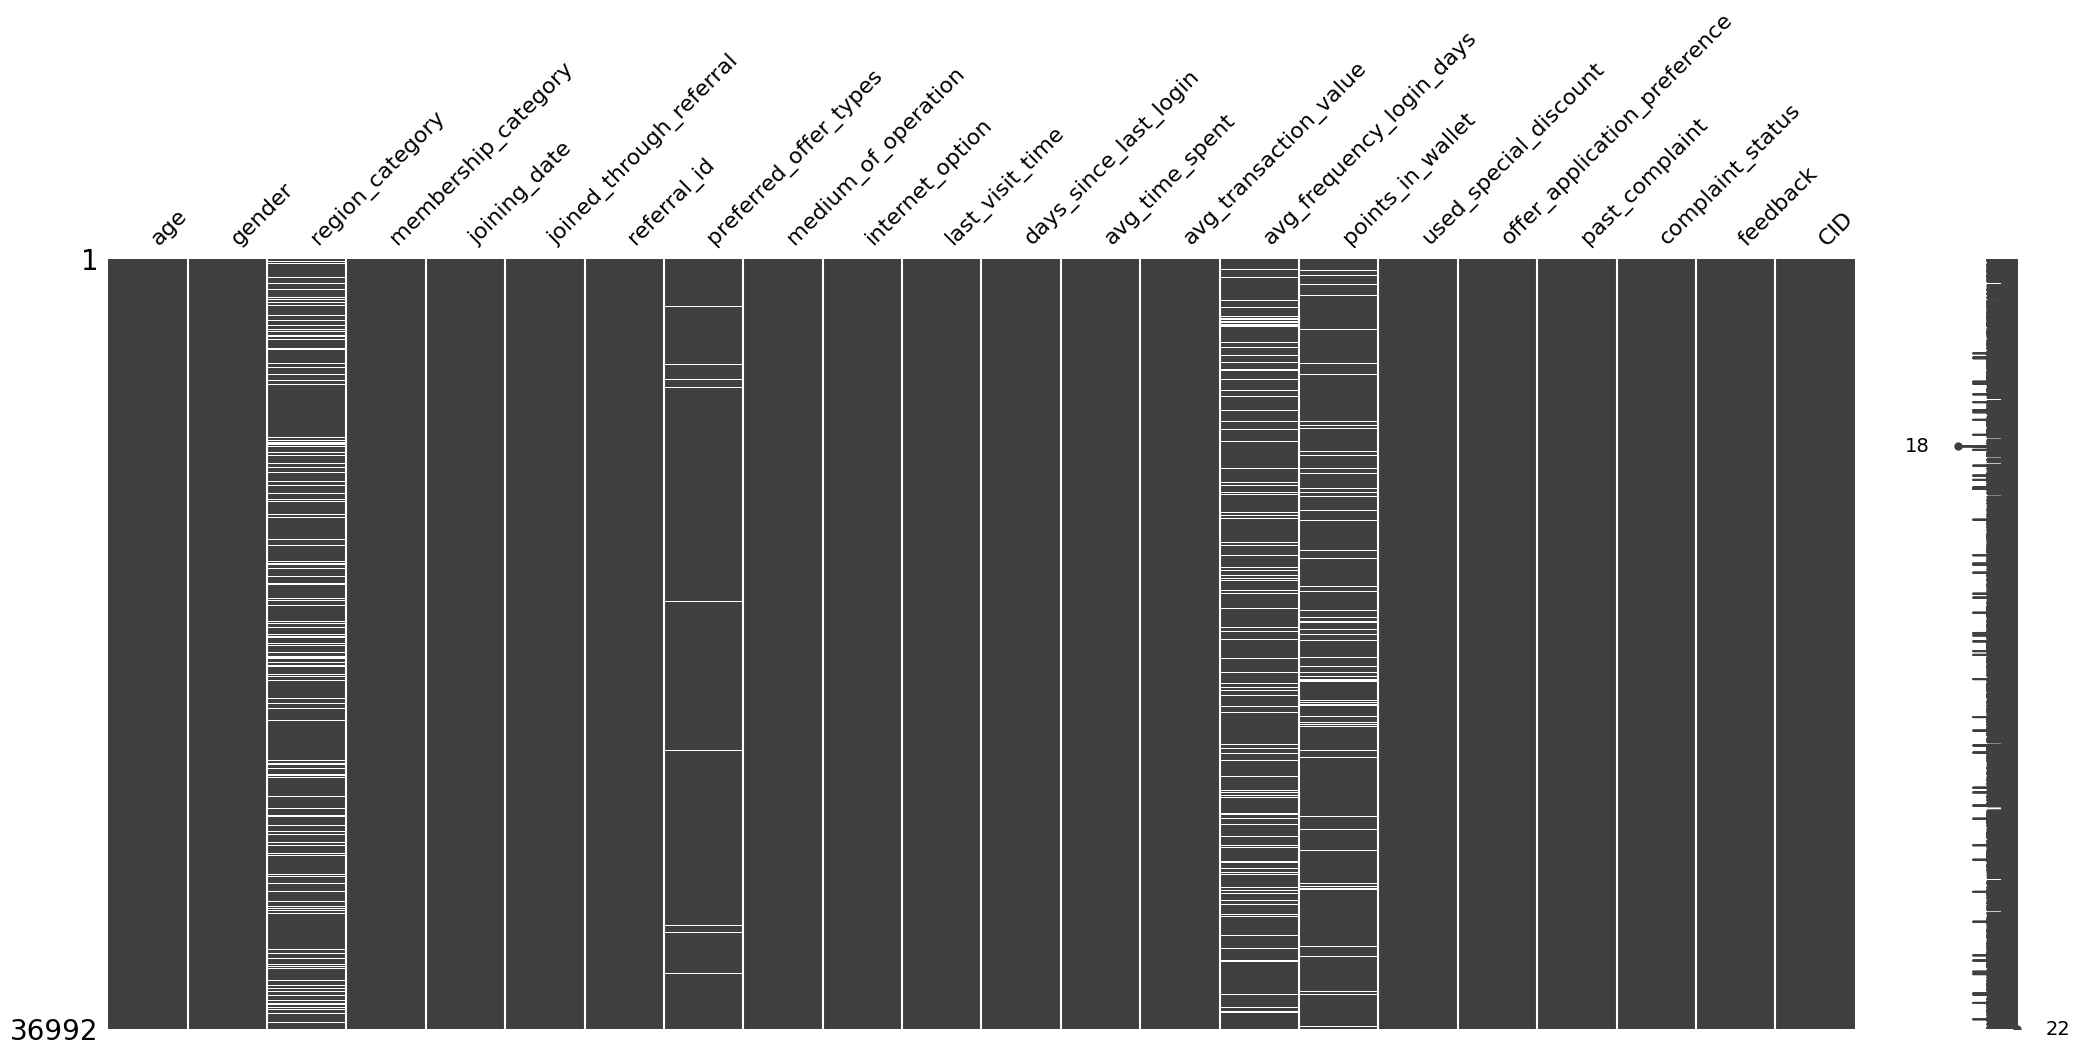

In [17]:
# Use missingno to look for a pattern in missing values. 
msno.matrix(X)

In [18]:
# Look for msssing values in numbers 
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   age                           36992 non-null  int64   
 1   gender                        36992 non-null  category
 2   region_category               31564 non-null  category
 3   membership_category           36992 non-null  object  
 4   joining_date                  36992 non-null  object  
 5   joined_through_referral       36992 non-null  object  
 6   referral_id                   36992 non-null  object  
 7   preferred_offer_types         36704 non-null  category
 8   medium_of_operation           36992 non-null  category
 9   internet_option               36992 non-null  category
 10  last_visit_time               36992 non-null  object  
 11  days_since_last_login         36992 non-null  int64   
 12  avg_time_spent                36992 non-null  

We don't drop complete rows with NaN. We look for the NaN at the features in detail.

For aesthetic reasons we rename values of 'joined_through_refferal' from "?" to "Unknown"

In [19]:
# Change "?" to "Unknown"
X_train.joined_through_referral[X_train.joined_through_referral == "?"] = "Unknown"
X_test.joined_through_referral[X_test.joined_through_referral == "?"] = "Unknown"
X_train.joined_through_referral.unique()

array(['Yes', 'No', 'Unknown'], dtype=object)

Concat X and y back to one DataFrame to keep the 

In [20]:
# Concat first so we do not lose the correct assignment of the target
df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

# Drop 'days_since_last_login' with value -999 
df_train = df_train[X_train.days_since_last_login != -999]
df_test = df_test[X_test.days_since_last_login != -999]

Handling nan values in 'region_category' and 'preferred_offer_types'

In [24]:
# Region category includes many unknown values// impute by neutral category "Unknown"
df_train.region_category = df_train.region_category.astype("object")
df_train.region_category.fillna("Unknown", inplace= True)
df_train.region_category = df_train.region_category.astype("category")

df_test.region_category = df_test.region_category.astype("object")
df_test.region_category.fillna("Unknown", inplace = True)
df_test.region_category = df_test.region_category.astype("category")

#preferred offer types// drop nan because too few// avoid extreme minority class if imputing
df_train.dropna(subset= ["preferred_offer_types"], inplace= True)
df_test.dropna(subset= ["preferred_offer_types"], inplace= True)

Handling of missing numerical values

In [25]:
#impute numerical values by mean value
avg_frequency_login_days_mean = df_train.avg_frequency_login_days.mean()
df_train.avg_frequency_login_days.fillna(avg_frequency_login_days_mean, inplace = True)

points_in_wallet_mean = df_test.points_in_wallet.mean()
df_train.points_in_wallet.fillna(points_in_wallet_mean, inplace = True)

#!!! impute test data with mean from train data!!!
df_test.avg_frequency_login_days.fillna(avg_frequency_login_days_mean, inplace = True)
df_test.points_in_wallet.fillna(points_in_wallet_mean, inplace = True)



Check if all NaN are removed

In [26]:
df_test.isna().sum()

age                         0
gender                      0
region_category             0
membership_category         0
joined_through_referral     0
preferred_offer_types       0
medium_of_operation         0
internet_option             0
days_since_last_login       0
avg_time_spent              0
avg_transaction_value       0
avg_frequency_login_days    0
points_in_wallet            0
used_special_discount       0
complaint_status            0
feedback                    0
last_visit_time_hours       0
days_since_join             0
churn_risk_score            0
dtype: int64

Export DataFrame before On-Hot-Encoding for models which work without

In [27]:
# export before one-hot-encoding - for model like KNN and SVM
df_train.to_pickle('./data/df_train_KNN.pkl')
df_test.to_pickle('./data/df_test_KNN.pkl')

# Encoding

In [28]:
#one hot encode
to_ohe = ["gender",
          "region_category",
          "joined_through_referral",
          "preferred_offer_types", 
          "medium_of_operation", 
          "internet_option", 
          "used_special_discount", 
          "complaint_status", 
          "feedback"]

#column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop= "first", handle_unknown='ignore'), to_ohe)
    ],
    remainder='passthrough'  # Keep any remaining columns unchanged
)


# Fit and transform the data
data_encoded = preprocessor.fit_transform(df_train)
data_encoded_test = preprocessor.transform(df_test)

# Get column names for the one-hot encoded columns
column_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(to_ohe)

# Create a DataFrame with the one-hot encoded columns
df_train = pd.DataFrame(data_encoded, columns=list(column_names) + list(df_train.columns.drop(to_ohe)))
df_test = pd.DataFrame(data_encoded_test, columns=list(column_names) + list(df_test.columns.drop(to_ohe)))


Ordinal Scaling of ordinal category 'membership_category'

In [29]:
# Order of category we assumed
order = { "No Membership": 0,
         "Basic Membership": 1,
         "Silver Membership": 2,
         "Gold Membership": 3,
         "Platinum Membership": 4,
         "Premium Membership": 5}
# Ordinal encoding
df_train.membership_category = df_train.membership_category.map(order)
df_test.membership_category = df_test.membership_category.map(order)

Export encoded DataFrame 

In [31]:
# export before scaling - for Decision Tree
df_train.to_pickle('./data/df_train_dt.pkl')
df_test.to_pickle('./data/df_test_dt.pkl')

# Scaling

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27770 entries, 0 to 27769
Data columns (total 37 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   gender_M                                     27770 non-null  object
 1   gender_Unknown                               27770 non-null  object
 2   region_category_Town                         27770 non-null  object
 3   region_category_Unknown                      27770 non-null  object
 4   region_category_Village                      27770 non-null  object
 5   joined_through_referral_Unknown              27770 non-null  object
 6   joined_through_referral_Yes                  27770 non-null  object
 7   preferred_offer_types_Gift Vouchers/Coupons  27770 non-null  object
 8   preferred_offer_types_Without Offers         27770 non-null  object
 9   medium_of_operation_Both                     27770 non-null  object
 10  medium_of_

Scale numerical features with standard-scaler

In [33]:
num_features = ["age", "avg_time_spent", "avg_transaction_value", "avg_frequency_login_days", "points_in_wallet", "last_visit_time_hours", "days_since_join"]

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features)  # Scale selected columns
    ],
    remainder='passthrough'  # Keep any remaining columns unchanged
)

# Fit and transform the data
data_scaled = preprocessor.fit_transform(df_train)
data_scaled_test = preprocessor.transform(df_test)

# Convert the transformed data back to a DataFrame
df_train = pd.DataFrame(data_scaled, columns=num_features + list(df_train.columns.drop(num_features)))
df_test = pd.DataFrame(data_scaled_test, columns=num_features + list(df_test.columns.drop(num_features)))

Check result of scaling (mean must be 0)

In [34]:
df_train[num_features].mean()

age                         0.0
avg_time_spent              0.0
avg_transaction_value       0.0
avg_frequency_login_days    0.0
points_in_wallet            0.0
last_visit_time_hours       0.0
days_since_join             0.0
dtype: object

Export the final DataFrame

In [35]:
df_train.to_pickle('./data/df_train.pkl')
df_test.to_pickle('./data/df_test.pkl')

# To Do

### features to be further examined:
- 'feedback' group by positive and negative feedback

Next steps/second iteration:
- https://annahava.medium.com/too-many-categories-how-to-deal-with-categorical-features-of-high-cardinality-d4563cfe62d6
- https://www.datacamp.com/tutorial/categorical-data